In [74]:
# Load config
from config import UNetTraining
# from config import UNetTraining
config = UNetTraining.Configuration()

In [10]:
from config import colors
colors = colors.bcolors()

# 0. Imports

In [81]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
from rasterio.windows import Window

# import imgaug as ia
# from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
# from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
from sys import platform

if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

# 1. Training

### Get Label Area

In [13]:
import geopandas as gpd
labels_bounding_boxes = gpd.read_file(config.filepath_labels_bounding_boxes)

In [14]:
# get polygon coordinates 
import json
g = json.loads(labels_bounding_boxes.to_json())
coords = []
for polygon in range(len(g)):
    coords.append(g['features'][polygon]['geometry']['coordinates'][0])

0 : (29.995271839179495, -26.501297921923136, 30.001920300509017, -26.495656803219298)


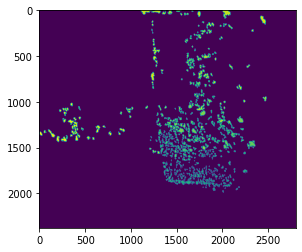

<AxesSubplot:>

1 : (29.748165906702567, -26.263430007776233, 29.76650030217796, -26.248664051688667)


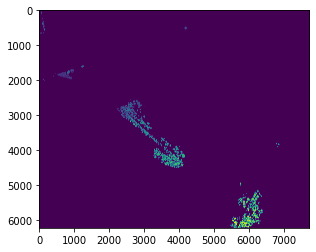

<AxesSubplot:>

In [15]:
from rasterio.windows import from_bounds
from rasterio.plot import show
# visualize labels
src_label = rasterio.open(config.filepath_label)
labels = []
coord_labels_bounding_boxes = []
for polygon in range(len(g)):
    west, south = coords[polygon][0][0], coords[polygon][0][1]
    east, north = coords[polygon][2][0], coords[polygon][2][1]
    coord_labels_bounding_boxes.append((west, south, east, north))
    print(polygon, ":", coord_labels_bounding_boxes[polygon])
    labels.append(src_label.read(1, window = from_bounds(west, south, east, north, src_label.transform)))
    show(labels[polygon])


In [16]:
from osgeo import gdal

label_file = gdal.Open(config.filepath_label)
filepath_labeled_areas = []
for polygon in range(len(g)):
    # same coordinates as above
    west, south = coords[polygon][0][0], coords[polygon][0][1]
    east, north = coords[polygon][2][0], coords[polygon][2][1]
    # gdal only needs the coordingates in a different order
    coord_labels_bounding_boxes.append((west, south, east, north))

    filepath_labeled_area = config.path_labeled_data_areas + "label-area-" + str(polygon) + ".tif"
    filepath_labeled_areas.append(filepath_labeled_area)
    cropped_window = (west,north,east,south) # coord_labels_bounding_boxes[polygon]
    # print(filepath_labeled_area)
    print(cropped_window)
    gdal.Translate(filepath_labeled_area, label_file, projWin = cropped_window)

(29.995271839179495, -26.495656803219298, 30.001920300509017, -26.501297921923136)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f7d4203c630> >

(29.748165906702567, -26.248664051688667, 29.76650030217796, -26.263430007776233)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f7cc9733150> >

In [17]:
# close rasterio & gdal dataset
src_label.close() 
del label_file

### Patchify

#### Create Label Area Patches

In [18]:
label_area_1 = rasterio.open(filepath_labeled_areas[0])
label_area_2 = rasterio.open(filepath_labeled_areas[1])
opened_label_areas = [label_area_1, label_area_2]

In [19]:
total_patches = 0
for x in [label_area_1, label_area_2]:
    x.width, x.height
    patches = round(x.width/224) * round(x.height/224)
    total_patches += patches
    print(total_patches)

(2802, 2377)

143


(7727, 6223)

1095


In [20]:
len(coord_labels_bounding_boxes)

4

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

satellite_img = rasterio.open(config.filepath_satellite)
label_img = rasterio.open(config.filepath_label)

In [22]:
%%time
# label_area. In other projects may be referred to as mask
patches_labels = []
for label_area in opened_label_areas:
    patches_labels = patchify(label_area.read(1), 
        (config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)
    # TODO: could also export patches to files like this:
    for i in range(patches_labels.shape[0]):
        for j in range(patches_labels.shape[1]):
            single_patch = patches_labels[i, j,:,:]
    #         filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[:-4] # -4 to cut off the .tif file extension
    #         filepath_single_patch = "{}-{}-patch-{}-{}.tif".format(config.path_patches_masks, filename, i, j)
    #         # gdal.Translate(filepath_single_patch, single_patch, projWin = )
    #         # single_patch.write(filepath_single_patch)
print("Mask/Label Patch Shape:", patches_labels.shape)

Mask/Label Patch Shape: (27, 34, 256, 256)
CPU times: user 102 ms, sys: 161 ms, total: 264 ms
Wall time: 269 ms


In [23]:
patches_labels.shape

(27, 34, 256, 256)

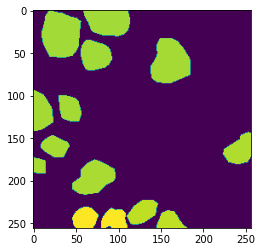

<AxesSubplot:>

In [24]:
# visualize single patch
show(patches_labels[17][16])

#### Create Satellite Area Patches

In [25]:
%%time
patches_satellite = []
for index, label_area in enumerate(opened_label_areas):
    # get coordinates
    cur_coords = coord_labels_bounding_boxes[index]
    (west, south, east, north) = cur_coords
    print(cur_coords)
    
    satellite_area = satellite_img.read([1,2,3], window = from_bounds(west, south, east, north, satellite_img.transform))
    
    cropped_window = (west,north,east,south)
    filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[6:-4] # -4 to cut off the .tif file extension and 6 to cut off label
    filepath_satellite_area = "{}areas/{}.tif".format(config.path_patches_satellite, filename)

    patches_satellite = patchify(satellite_area, 
        (3, config.patch_size[0], config.patch_size[1]), 
        step=config.patch_size[0]-config.overlap)[0]
    
    # or reshape now:
    # satellite_area_reshaped = np.reshape(satellite_area, (satellite_area.shape[1],satellite_area.shape[2],3))
    # patches_satellite = patchify(satellite_area_reshaped, 
    #     (config.patch_size[0], config.patch_size[1], 3), 
    #     step=config.patch_size[0]-config.overlap)[0]

    # TODO: SAVE TO SEPARATE IMG + LOAD IT
    # gdal.Translate(filepath_satellite_area, satellite_area, projWin = cropped_window)
    # could also export patches to files like this:
    # for i in range(patches_satellite.shape[0]):
    #     for j in range(patches_satellite.shape[1]):
    #         single_patch = patches_satellite[i, j,:,:]
    #         filename = opened_label_areas[0].name.replace(config.path_labeled_data_areas,"")[:-4] # -4 to cut off the .tif file extension
    #         filepath_single_patch = "{}-{}-patch-{}-{}.tif".format(config.path_patches_masks, filename, i, j)
    #         # gdal.Translate(filepath_single_patch, single_patch, projWin = )
    #         # single_patch.write(filepath_single_patch)
print("Satellite Patch Shape:", patches_satellite.shape)

(29.995271839179495, -26.501297921923136, 30.001920300509017, -26.495656803219298)
(29.748165906702567, -26.263430007776233, 29.76650030217796, -26.248664051688667)
Satellite Patch Shape: (27, 34, 3, 256, 256)
CPU times: user 2.27 s, sys: 1.35 s, total: 3.62 s
Wall time: 3.82 s


In [26]:
(3, config.patch_size[0:2], config.patch_size[1])

(3, (256, 256), 256)

In [27]:
label_area.read(1).shape
satellite_area.shape

(6223, 7727)

(3, 6222, 7726)

In [28]:
satellite_area_reshaped = np.reshape(satellite_area, (satellite_area.shape[1],satellite_area.shape[2],3))
satellite_area_reshaped.shape

(6222, 7726, 3)

In [29]:
patches_labels.shape
patches_satellite.shape

(27, 34, 256, 256)

(27, 34, 3, 256, 256)

### Data Augmentation & Feature Scaling (still to do)

### Compile Model

In [75]:
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [88]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_114[0][0]                 
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 256, 256, 64) 256         conv2d_115[0][0]                 
____________________________________________________________________________________________

In [89]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

### Data Preparation for Training

#### Reshape Patches to Fit to the Model

In [37]:
patches_satellite.shape
patches_labels.shape

(27, 34, 3, 256, 256)

(27, 34, 256, 256)

In [38]:
shape = patches_satellite.shape
patches_satellite_reshaped = patches_satellite.reshape(shape[0]*shape[1], shape[2], shape[3], shape[4])
patches_satellite_reshaped.shape

(918, 3, 256, 256)

In [39]:
shape = patches_labels.shape
patches_labels_reshaped = patches_labels.reshape(shape[0]*shape[1], shape[2], shape[3])
patches_labels_reshaped.shape

(918, 256, 256)

#### Create Training and Test Dataset

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches_satellite_reshaped, patches_labels_reshaped, test_size=config.test_ratio, random_state=42)

In [47]:
for i in [X_train, X_test, y_train, y_test]:
    i.shape

(734, 3, 256, 256)

(184, 3, 256, 256)

(734, 256, 256)

(184, 256, 256)

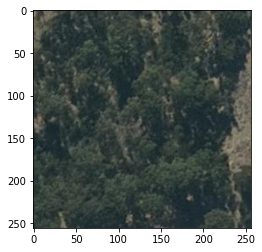

<AxesSubplot:>

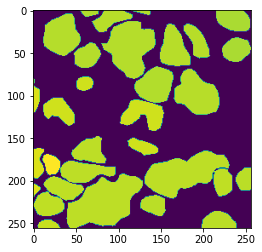

<AxesSubplot:>

In [45]:
# sanity check: check if satellite and label data matches
x = 16
show(X_train[x])
show(y_train[x])

In [78]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3], X_test.shape[1])
# X_train, X_test, y_train, y_test

### Training

- Maybe Model defined to only receive one input and not rgb => test out or look into model | but project has 2 color channels
- maybe data generator adjusts data? But does not affect model

In [96]:
%%time
loss_history = [model.fit(x=X_train_reshaped,
                        y=y_train,
                        epochs=config.NB_EPOCHS, 
                        # validation_data=y_train,
                        steps_per_epoch=config.MAX_TRAIN_STEPS,
                        # validation_steps=config.VALID_IMG_COUNT,
                        batch_size=config.BATCH_SIZE,
                        callbacks=callbacks_list,
                        # workers=1,
                        # use_multiprocessing=True # the generator is not very thread safe
                )]

Epoch 1/200
   9/1000 [..............................] - ETA: 23:16:33 - loss: -0.2109 - dice_coef: 2.5158 - dice_loss: -1.5158 - specificity: 0.0707 - sensitivity: nan - accuracy: 0.0912

KeyboardInterrupt: 

# 2. Evaluation

# 3. Prediction

# 9. YT Video: Preview of Test Prediction

In [ ]:
#Load previously saved model
from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5", compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
# if model is more than 50% sure it is a cell, it returns True, else False
y_pred_thresholded = y_pred > 0.5 

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()